In [29]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.ar_model import AutoReg 
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


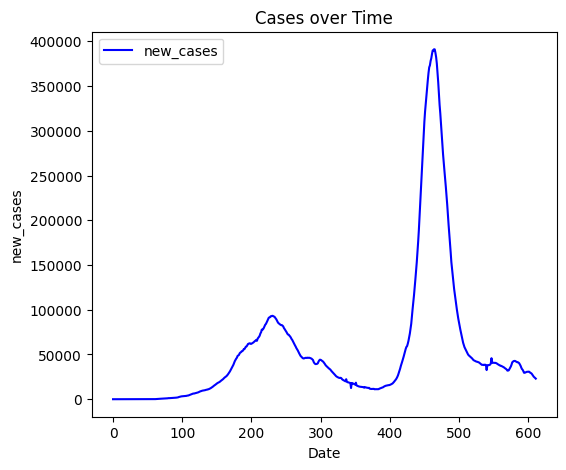

In [4]:
df=pd.read_csv('daily_covid_cases.csv')
df.plot(y="new_cases", title="Cases over Time", figsize=(6,5), color='blue')
plt.xlabel("Date")
plt.ylabel("new_cases")
plt.show()

In [10]:
df["lag_1"] = df["new_cases"].shift(1)

print(df)
# Compute correlation with one-day lag values
correlation, _ = pearsonr(df.dropna()["new_cases"], df.dropna()["lag_1"])
print(f"Pearson correlation for one-day lag: {correlation:.4f}")

           Date    new_cases        lag_1
0    2020-01-30      0.00000          NaN
1    2020-01-31      0.00000      0.00000
2    2020-02-01      0.33333      0.00000
3    2020-02-02      0.50000      0.33333
4    2020-02-03      0.60000      0.50000
..          ...          ...          ...
607  2021-09-28  26421.85714  27578.14286
608  2021-09-29  25222.71429  26421.85714
609  2021-09-30  24557.71429  25222.71429
610  2021-10-01  23806.00000  24557.71429
611  2021-10-02  23022.57143  23806.00000

[612 rows x 3 columns]
Pearson correlation for one-day lag: 0.9991


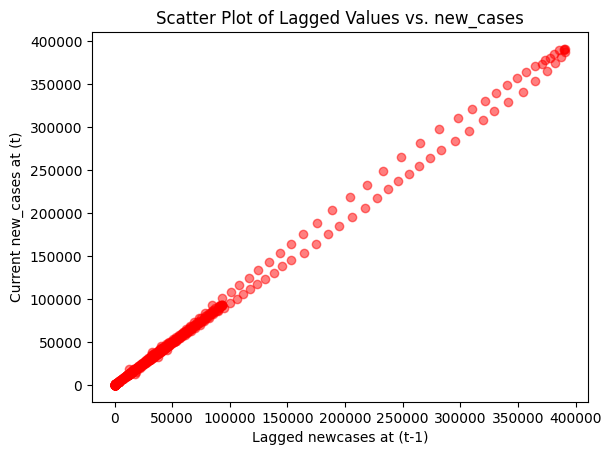

In [8]:
# Scatter plot for one-day lag correlation
plt.scatter(df["lag_1"], df["new_cases"], alpha=0.5, color='red')
plt.xlabel("Lagged newcases at (t-1)")
plt.ylabel("Current new_cases at (t)")
plt.title("Scatter Plot of Lagged Values vs. new_cases")
plt.show()

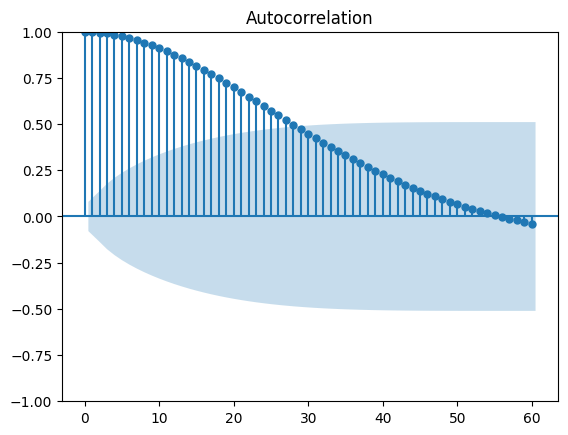

In [11]:
plot_acf(df.dropna()["new_cases"], lags=60)
plt.show()

AR(5) Model Coefficients:
const           59.954833
new_cases.L1     1.036759
new_cases.L2     0.261712
new_cases.L3     0.027561
new_cases.L4    -0.175392
new_cases.L5    -0.152461
dtype: float64

Test RMSE: 1923.59 µg/m³
Test MAPE: 1.57%


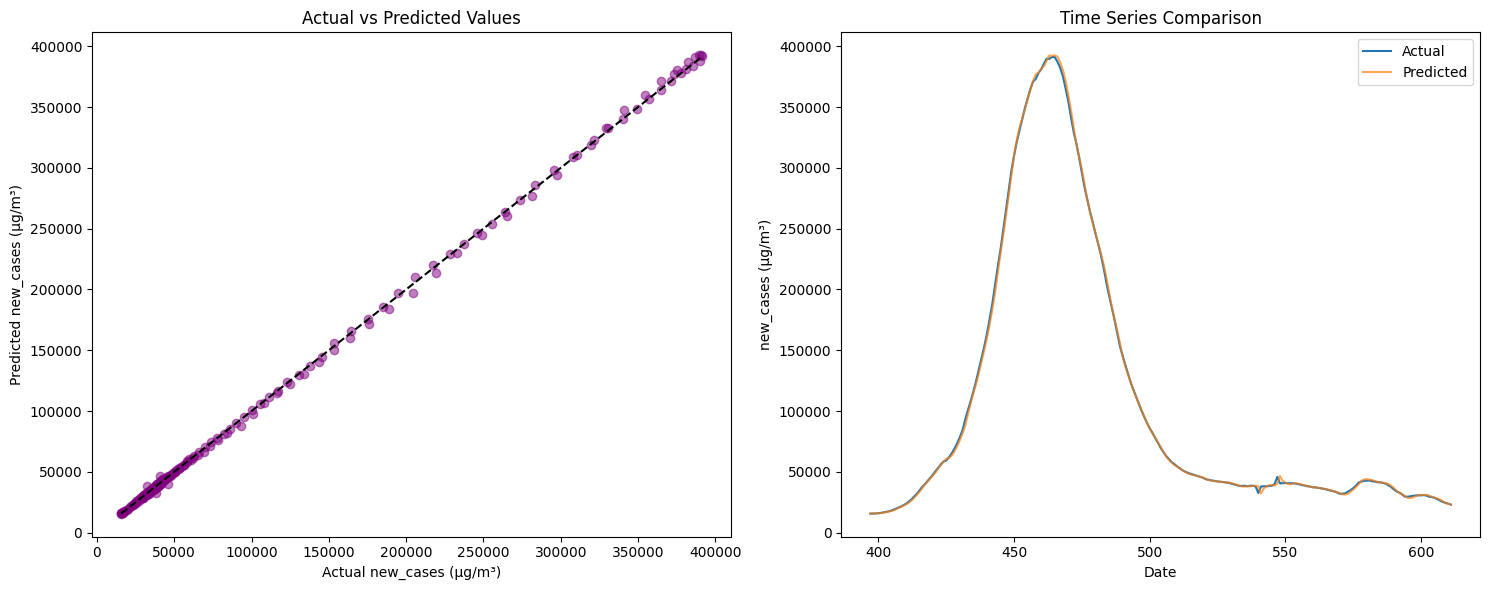

In [30]:
df = df.dropna(subset=['new_cases'])

# Convert index to proper datetime with frequency (to avoid the warning)

# 2(a): Train-test split (65-35)
train_size = int(len(df) * 0.65)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Train AR(5) model
lag = 5
model = AutoReg(train["new_cases"], lags=lag, old_names=False).fit()
coef = model.params
print(f"AR({lag}) Model Coefficients:\n{coef}")

# Make predictions
history = train["new_cases"].values.tolist()
predictions = []
for t in range(len(test)):
    lag_values = history[-lag:]
    # Use iloc to avoid position-based indexing warning
    yhat = coef.iloc[0] + sum(coef.iloc[i+1] * lag_values[lag-i-1] for i in range(lag))
    predictions.append(yhat)
    history.append(test["new_cases"].iloc[t])

# Convert predictions to numpy array for plotting
predictions = np.array(predictions)

# Evaluation metrics
test_rmse = np.sqrt(mean_squared_error(test["new_cases"], predictions))
try:
    test_mape = mean_absolute_percentage_error(test["new_cases"], predictions) * 100
except:
    # Handle cases where actual values might be zero
    test_mape = np.mean(np.abs((test["new_cases"] - predictions) / test["new_cases"].replace(0, 1))) * 100

print(f"\nTest RMSE: {test_rmse:.2f} µg/m³")
print(f"Test MAPE: {test_mape:.2f}%")

# Visualization
plt.figure(figsize=(15, 6))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(test["new_cases"], predictions, alpha=0.5, color='purple')
plt.plot([test["new_cases"].min(), test["new_cases"].max()], 
         [test["new_cases"].min(), test["new_cases"].max()], 'k--')
plt.xlabel("Actual new_cases (µg/m³)")
plt.ylabel("Predicted new_cases (µg/m³)")
plt.title("Actual vs Predicted Values")

# Time series plot
plt.subplot(1, 2, 2)
# Convert index to numpy array for plotting
plt.plot(test.index.to_numpy(), test["new_cases"].to_numpy(), label='Actual')
plt.plot(test.index.to_numpy(), predictions, label='Predicted', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("new_cases (µg/m³)")
plt.title("Time Series Comparison")
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 500x400 with 0 Axes>

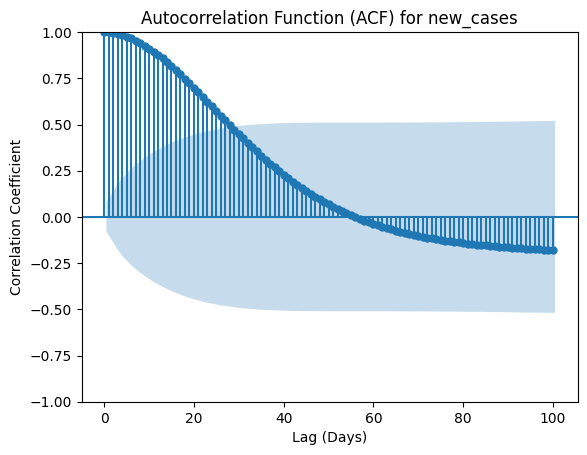

In [24]:
plt.figure(figsize=(5, 4))
plot_acf(df['new_cases'], lags=100, alpha=0.05, title='Autocorrelation Function (ACF) for new_cases')
plt.xlabel("Lag (Days)")
plt.ylabel("Correlation Coefficient")
plt.show()